### Test running real jets without whitening

In [31]:
import h5py as h5
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Dense, TimeDistributed

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_train.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_train.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_test.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_test.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_val.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_val.h5'
]

def load_data(filepath):
    with h5.File(filepath, "r") as h5f:
        particles = h5f['data'][()].astype(np.float32)
        jets = h5f['jet'][()].astype(np.float32)
    return particles, jets

real_gluon_parts, real_gluon_jets = load_data(filepaths[0])
real_top_parts, real_top_jets = load_data(filepaths[1])
real_gluon_parts_test, real_gluon_jets_test = load_data(filepaths[2])
real_top_parts_test, real_top_jets_test = load_data(filepaths[3])
real_gluon_parts_val, real_gluon_jets_val = load_data(filepaths[4])
real_top_parts_val, real_top_jets_val = load_data(filepaths[5])

def select_top_particles(particles, num_particles=5):
    top_indices = np.argsort(particles[:, :, 2], axis=1)[:, -num_particles:]
    return np.take_along_axis(particles, np.expand_dims(top_indices, axis=-1), axis=1)

real_gluon_parts = select_top_particles(real_gluon_parts)
real_top_parts = select_top_particles(real_top_parts)
real_gluon_parts_test = select_top_particles(real_gluon_parts_test)
real_top_parts_test = select_top_particles(real_top_parts_test)
real_gluon_parts_val = select_top_particles(real_gluon_parts_val)
real_top_parts_val = select_top_particles(real_top_parts_val)

real_gluon_parts_combined = np.concatenate([real_gluon_parts, real_gluon_parts_test, real_gluon_parts_val], axis=0)
real_gluon_jets_combined = np.concatenate([real_gluon_jets, real_gluon_jets_test, real_gluon_jets_val], axis=0)
real_top_parts_combined = np.concatenate([real_top_parts, real_top_parts_test, real_top_parts_val], axis=0)
real_top_jets_combined = np.concatenate([real_top_jets, real_top_jets_test, real_top_jets_val], axis=0)

def combine_features(particles, jets):
    mask = np.any(particles != 0, axis=-1, keepdims=True)
    jets_expanded = np.repeat(jets[:, np.newaxis, :], particles.shape[1], axis=1)
    jets_masked = jets_expanded * mask
    combined = np.concatenate([particles, jets_masked], axis=-1)
    return combined

real_gluon_combined = combine_features(real_gluon_parts_combined, real_gluon_jets_combined)
real_top_combined = combine_features(real_top_parts_combined, real_top_jets_combined)

labels_gluon_real = np.zeros((real_gluon_combined.shape[0], 1))
labels_top_real = np.ones((real_top_combined.shape[0], 1))

X_real = np.concatenate([real_gluon_combined[:600000], real_top_combined[:600000]])
y_real = np.concatenate([labels_gluon_real[:600000], labels_top_real[:600000]])

X_test_real = np.concatenate([real_gluon_combined[600000:], real_top_combined[600000:]])
y_test_real = np.concatenate([labels_gluon_real[600000:], labels_top_real[600000:]])

scaler_real = StandardScaler()
X_flattened_real = X_real.reshape(X_real.shape[0], -1)
X_test_flattened_real = X_test_real.reshape(X_test_real.shape[0], -1)

X_scaled_real = scaler_real.fit_transform(X_flattened_real)
X_test_scaled_real = scaler_real.transform(X_test_flattened_real)

X_scaled_real = X_scaled_real.reshape(X_real.shape)
X_test_scaled_real = X_test_scaled_real.reshape(X_test_real.shape)

X_train_real, X_val_real, y_train_real, y_val_real = train_test_split(X_scaled_real, y_real, test_size=0.2, random_state=42)

def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Print shapes to confirm
print("Combined real_gluon_parts shape:", real_gluon_parts_combined.shape)
print("Combined real_gluon_jets shape:", real_gluon_jets_combined.shape)
print("Combined real_top_parts shape:", real_top_parts_combined.shape)
print("Combined real_top_jets shape:", real_top_jets_combined.shape)

Combined real_gluon_parts shape: (1008940, 5, 3)
Combined real_gluon_jets shape: (1008940, 2)
Combined real_top_parts shape: (1009060, 5, 3)
Combined real_top_jets shape: (1009060, 2)


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LayerNormalization, MultiHeadAttention, GlobalAvgPool1D, LeakyReLU, Dropout

model_cr = DeepSetsAttClass(num_feat=5, num_transformer=5)

model_cr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [3]:
early_stopping_cr = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_cr = ModelCheckpoint('cr_transformers_checkpoints/5particle_5transformer_checkpoint_{epoch:02d}.h5', save_weights_only=True, period=5, verbose=1)

history_real = model_cr.fit(X_train_real, y_train_real,
                    validation_data=(X_val_real, y_val_real),
                    epochs=128,
                    batch_size=32,
                    callbacks=[early_stopping_cr, model_checkpoint_cr])

Epoch 1/128


2024-05-22 04:30:58.614119: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30000/30000 [==============================] - 229s 7ms/step - loss: 0.2273 - accuracy: 0.9066 - val_loss: 0.2101 - val_accuracy: 0.9109
Epoch 2/128
30000/30000 [==============================] - 218s 7ms/step - loss: 0.2112 - accuracy: 0.9124 - val_loss: 0.2072 - val_accuracy: 0.9129
Epoch 3/128
30000/30000 [==============================] - 206s 7ms/step - loss: 0.2076 - accuracy: 0.9136 - val_loss: 0.2034 - val_accuracy: 0.9145
Epoch 4/128
30000/30000 [==============================] - 210s 7ms/step - loss: 0.2057 - accuracy: 0.9147 - val_loss: 0.2048 - val_accuracy: 0.9151
Epoch 5/128
29994/30000 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9149
Epoch 5: saving model to cr_transformers_checkpoints/5particle_5transformer_checkpoint_05.h5
30000/30000 [==============================] - 203s 7ms/step - loss: 0.2044 - accuracy: 0.9149 - val_loss: 0.2023 - val_accuracy: 0.9153
Epoch 6/128
30000/30000 [==============================] - 204s 7ms/step - loss: 0.20

In [ ]:
import json
with open('/pscratch/sd/n/nishank/scripts/history_transformers/history_cr_5particle_5transformer.json', 'w') as f:
    json.dump(history_real.history, f)

In [4]:
model_cr.save('5particle_5transformer_combined_real.h5')

In [33]:
model_cr.load_weights('5particle_5transformer_combined_real.h5')

predictions_cr = model_cr.predict(X_test_scaled_real)

25563/25563 [==============================] - 98s 4ms/step


Classifier AUC: 0.9741360661156369


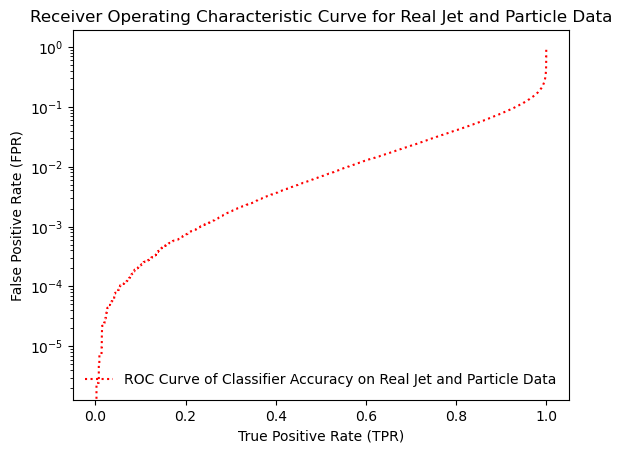

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_real, tpr_combine_real, _ = roc_curve(y_test_real,predictions_cr, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_real, tpr_combine_real)))
plt.plot(tpr_combine_real,fpr_combine_real,label="ROC Curve of Classifier Accuracy on Real Jet and Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Real Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

### Test running real jets with whitening

### Test running generated jets with whitening

In [1]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, TimeDistributed
import numpy as np
import h5py as h5
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_gluon_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_gluon_ll.h5'
]

def load_data(filepath):
    with h5.File(filepath, "r") as h5f:
        particles = h5f['data'][()].astype(np.float32)
        jets = h5f['jet'][()].astype(np.float32)
        normal_particles = h5f['normal_data'][()].astype(np.float32)
        normal_jets = h5f['normal_jet'][()].astype(np.float32)
    return particles, jets, normal_particles, normal_jets

gen_gluon_parts, gen_gluon_jets, gluon_parts, gluon_jets = load_data(filepaths[0])
gen_top_parts, gen_top_jets, top_parts, top_jets = load_data(filepaths[1])

print(gen_gluon_parts.shape)
print(gen_gluon_jets.shape)
print(gluon_parts.shape)
print(gluon_jets.shape)
print(gen_top_parts.shape)
print(gen_top_jets.shape)
print(top_parts.shape)
print(top_jets.shape)

def select_top_particles(particles, num_particles=5):
    top_indices = np.argsort(particles[:, :, 2], axis=1)[:, -num_particles:]
    return np.take_along_axis(particles, np.expand_dims(top_indices, axis=-1), axis=1)

gen_gluon_parts = select_top_particles(gen_gluon_parts)
gluon_parts = select_top_particles(gluon_parts)
gen_top_parts = select_top_particles(gen_top_parts)
top_parts = select_top_particles(top_parts)

def combine_features(particles, jets):
    mask = np.any(particles != 0, axis=-1, keepdims=True)
    jets_expanded = np.repeat(jets[:, np.newaxis, :], particles.shape[1], axis=1)
    jets_masked = jets_expanded * mask
    combined = np.concatenate([particles, jets_masked], axis=-1)
    return combined

gen_gluon_combined = combine_features(gen_gluon_parts, gen_gluon_jets)
gen_top_combined = combine_features(gen_top_parts, gen_top_jets)

labels_gluon = np.zeros((gen_gluon_combined.shape[0], 1))
labels_top = np.ones((gen_top_combined.shape[0], 1))

X = np.concatenate([gen_gluon_combined[:600000], gen_top_combined[:600000]])
y = np.concatenate([labels_gluon[:600000], labels_top[:600000]])

X_test = np.concatenate([gen_gluon_combined[600000:], gen_top_combined[600000:]])
y_test = np.concatenate([labels_gluon[600000:], labels_top[600000:]])

# Whitening (Standardization and decorrelation)
pca = PCA(whiten=True)
X_flattened = X.reshape(X.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

X_whitened = pca.fit_transform(X_flattened)
X_test_whitened = pca.transform(X_test_flattened)

X_whitened = X_whitened.reshape(X.shape)
X_test_whitened = X_test_whitened.reshape(X_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_whitened, y, test_size=0.2, random_state=42)

def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Print shapes to confirm
print("Reduced gen_gluon_parts shape:", gen_gluon_parts.shape)
print("Reduced gen_gluon_jets shape:", gen_gluon_jets.shape)
print("Reduced gluon_parts shape:", gluon_parts.shape)
print("Reduced gluon_jets shape:", gluon_jets.shape)
print("Reduced gen_top_parts shape:", gen_top_parts.shape)
print("Reduced gen_top_jets shape:", gen_top_jets.shape)
print("Reduced top_parts shape:", top_parts.shape)
print("Reduced top_jets shape:", top_jets.shape)

(1000000, 100, 3)
(1000000, 2)
(1000000, 100, 3)
(1000000, 2)
(1000000, 100, 3)
(1000000, 2)
(1000000, 100, 3)
(1000000, 2)
Reduced gen_gluon_parts shape: (1000000, 5, 3)
Reduced gen_gluon_jets shape: (1000000, 2)
Reduced gluon_parts shape: (1000000, 5, 3)
Reduced gluon_jets shape: (1000000, 2)
Reduced gen_top_parts shape: (1000000, 5, 3)
Reduced gen_top_jets shape: (1000000, 2)
Reduced top_parts shape: (1000000, 5, 3)
Reduced top_jets shape: (1000000, 2)


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming your model definition is already provided and instantiated
model_cg = DeepSetsAttClass(num_feat=5, num_transformer=5)

model_cg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2024-05-28 13:57:55.550552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:57:58.364816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-05-28 13:57:58.372806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38218 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-05-28 13:57:58.374462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [3]:
import json

early_stopping_cg = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_cg = ModelCheckpoint('cg_transformers_checkpoints/5particle_5transformer_checkpoint_{epoch:02d}.h5', save_weights_only=True, period=5, verbose=1)

history = model_cg.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=128,
                    batch_size=32,
                    callbacks=[early_stopping_cg, model_checkpoint_cg])

Epoch 1/128


2024-05-28 13:58:06.537062: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


30000/30000 [==============================] - 223s 7ms/step - loss: 0.2864 - accuracy: 0.8798 - val_loss: 0.2596 - val_accuracy: 0.8909
Epoch 2/128
30000/30000 [==============================] - 208s 7ms/step - loss: 0.2535 - accuracy: 0.8942 - val_loss: 0.2480 - val_accuracy: 0.8956
Epoch 3/128
30000/30000 [==============================] - 209s 7ms/step - loss: 0.2428 - accuracy: 0.8985 - val_loss: 0.2383 - val_accuracy: 0.9006
Epoch 4/128
30000/30000 [==============================] - 210s 7ms/step - loss: 0.2359 - accuracy: 0.9016 - val_loss: 0.2320 - val_accuracy: 0.9031
Epoch 5/128
29999/30000 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9036
Epoch 5: saving model to cg_transformers_checkpoints/5particle_5transformer_checkpoint_05.h5
30000/30000 [==============================] - 209s 7ms/step - loss: 0.2315 - accuracy: 0.9036 - val_loss: 0.2289 - val_accuracy: 0.9045
Epoch 6/128
30000/30000 [==============================] - 212s 7ms/step - loss: 0.22

In [5]:
model_cg.save('5particle_5transformer_combined_gen.h5')
predictions_cg = model_cg.predict(X_test_whitened)

25000/25000 [==============================] - 61s 2ms/step


Classifier AUC: 0.94600179485625


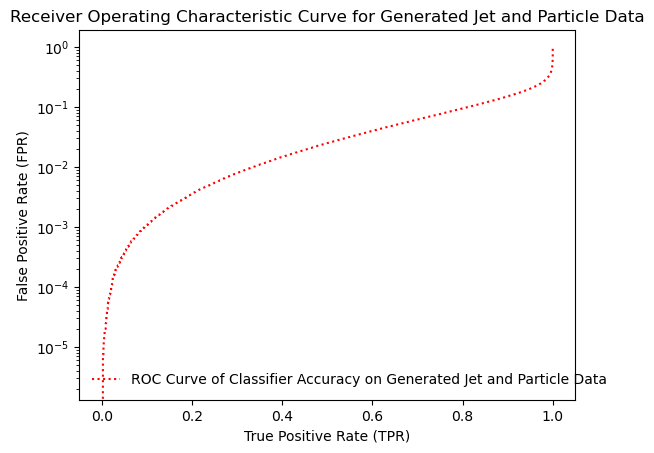

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_gen, tpr_combine_gen, _ = roc_curve(y_test,predictions_cg, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_gen, tpr_combine_gen)))
plt.plot(tpr_combine_gen,fpr_combine_gen,label="ROC Curve of Classifier Accuracy on Generated Jet and Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Generated Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

### Test running generated jets without whitening


In [21]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, TimeDistributed
import numpy as np
import h5py as h5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_gluon_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_gluon_ll.h5'
]

def load_data(filepath):
    with h5.File(filepath, "r") as h5f:
        particles = h5f['data'][()].astype(np.float32)
        jets = h5f['jet'][()].astype(np.float32)
        normal_particles = h5f['normal_data'][()].astype(np.float32)
        normal_jets = h5f['normal_jet'][()].astype(np.float32)
    return particles, jets, normal_particles, normal_jets

gen_gluon_parts, gen_gluon_jets, gluon_parts, gluon_jets = load_data(filepaths[0])
gen_top_parts, gen_top_jets, top_parts, top_jets = load_data(filepaths[1])

print(gen_gluon_parts.shape)
print(gen_gluon_jets.shape)
print(gluon_parts.shape)
print(gluon_jets.shape)
print(gen_top_parts.shape)
print(gen_top_jets.shape)
print(top_parts.shape)
print(top_jets.shape)

def select_top_particles(particles, num_particles=5):
    top_indices = np.argsort(particles[:, :, 2], axis=1)[:, -num_particles:]
    return np.take_along_axis(particles, np.expand_dims(top_indices, axis=-1), axis=1)

gen_gluon_parts = select_top_particles(gen_gluon_parts)
gluon_parts = select_top_particles(gluon_parts)
gen_top_parts = select_top_particles(gen_top_parts)
top_parts = select_top_particles(top_parts)

def combine_features(particles, jets):
    mask = np.any(particles != 0, axis=-1, keepdims=True)
    jets_expanded = np.repeat(jets[:, np.newaxis, :], particles.shape[1], axis=1)
    jets_masked = jets_expanded * mask
    combined = np.concatenate([particles, jets_masked], axis=-1)
    return combined

gen_gluon_combined = combine_features(gen_gluon_parts, gen_gluon_jets)
gen_top_combined = combine_features(gen_top_parts, gen_top_jets)

labels_gluon = np.zeros((gen_gluon_combined.shape[0], 1))
labels_top = np.ones((gen_top_combined.shape[0], 1))

X = np.concatenate([gen_gluon_combined[:600000], gen_top_combined[:600000]])
y = np.concatenate([labels_gluon[:600000], labels_top[:600000]])

X_test = np.concatenate([gen_gluon_combined[600000:], gen_top_combined[600000:]])
y_test = np.concatenate([labels_gluon[600000:], labels_top[600000:]])

# Standardization
scaler = StandardScaler()
X_flattened = X.reshape(X.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

X_scaled = scaler.fit_transform(X_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

X_scaled = X_scaled.reshape(X.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Print shapes to confirm
print("Reduced gen_gluon_parts shape:", gen_gluon_parts.shape)
print("Reduced gen_gluon_jets shape:", gen_gluon_jets.shape)
print("Reduced gluon_parts shape:", gluon_parts.shape)
print("Reduced gluon_jets shape:", gluon_jets.shape)
print("Reduced gen_top_parts shape:", gen_top_parts.shape)
print("Reduced gen_top_jets shape:", gen_top_jets.shape)
print("Reduced top_parts shape:", top_parts.shape)
print("Reduced top_jets shape:", top_jets.shape)

(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
Reduced gen_gluon_parts shape: (1600000, 5, 3)
Reduced gen_gluon_jets shape: (1600000, 2)
Reduced gluon_parts shape: (1600000, 5, 3)
Reduced gluon_jets shape: (1600000, 2)
Reduced gen_top_parts shape: (1600000, 5, 3)
Reduced gen_top_jets shape: (1600000, 2)
Reduced top_parts shape: (1600000, 5, 3)
Reduced top_jets shape: (1600000, 2)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming your model definition is already provided and instantiated
model_cg = DeepSetsAttClass(num_feat=5, num_transformer=5)

model_cg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import json

early_stopping_cg = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_cg = ModelCheckpoint('cg_transformers_checkpoints/norm_5particle_5transformer_checkpoint_{epoch:02d}.h5', save_weights_only=True, period=5, verbose=1)

history = model_cg.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=128,
                    batch_size=32,
                    callbacks=[early_stopping_cg, model_checkpoint_cg])

Epoch 1/128
30000/30000 [==============================] - 214s 7ms/step - loss: 0.2287 - accuracy: 0.9067 - val_loss: 0.2172 - val_accuracy: 0.9112
Epoch 2/128
30000/30000 [==============================] - 212s 7ms/step - loss: 0.2145 - accuracy: 0.9119 - val_loss: 0.2137 - val_accuracy: 0.9117
Epoch 3/128
30000/30000 [==============================] - 210s 7ms/step - loss: 0.2109 - accuracy: 0.9132 - val_loss: 0.2092 - val_accuracy: 0.9137
Epoch 4/128
30000/30000 [==============================] - 209s 7ms/step - loss: 0.2093 - accuracy: 0.9139 - val_loss: 0.2100 - val_accuracy: 0.9140
Epoch 5/128
29994/30000 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9142
Epoch 5: saving model to cg_transformers_checkpoints/norm_5particle_5transformer_checkpoint_05.h5
30000/30000 [==============================] - 209s 7ms/step - loss: 0.2081 - accuracy: 0.9142 - val_loss: 0.2082 - val_accuracy: 0.9139
Epoch 6/128
30000/30000 [==============================] - 212s 7ms/

In [29]:
model_cg.load_weights('norm_5particle_5transformer_combined_gen.h5')
predictions_cg = model_cg.predict(X_test_scaled)

62500/62500 [==============================] - 151s 2ms/step


Classifier AUC: 0.972331992188


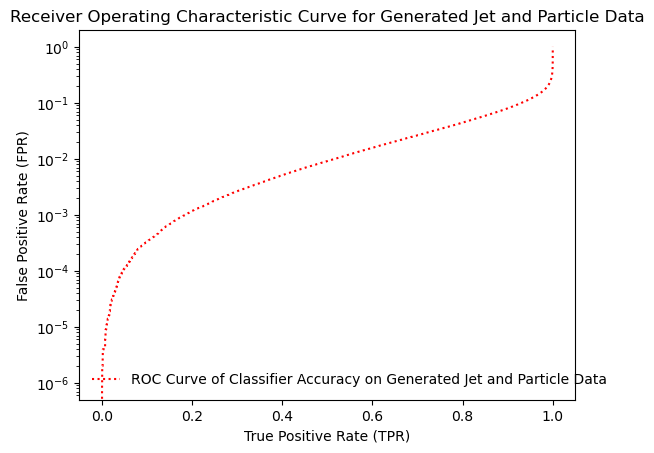

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_gen, tpr_combine_gen, _ = roc_curve(y_test,predictions_cg, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_gen, tpr_combine_gen)))
plt.plot(tpr_combine_gen,fpr_combine_gen,label="ROC Curve of Classifier Accuracy on Generated Jet and Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Generated Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

### Likelihood 

(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
Classifier AUC: 0.9830810216424999


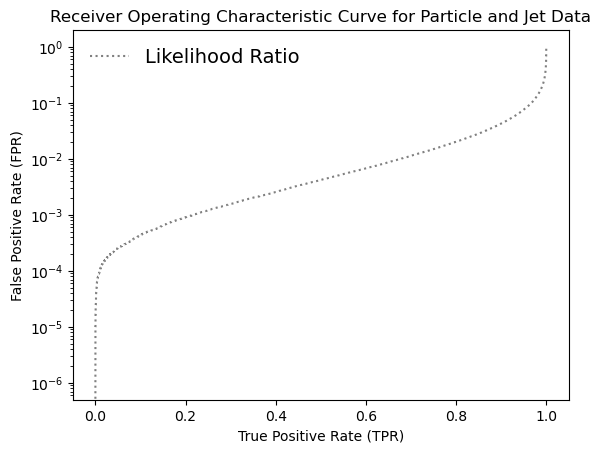

In [8]:
import numpy as np
import h5py as h5

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_gluon_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_gluon_ll.h5'
]

gluon_parts = []
gluon_jets = []
gen_gluon_parts = []
gen_gluon_jets = []
with h5.File(filepaths[0], "r") as h5f:
    gen_gluon_parts = h5f['data'][()].astype(np.float32)
    gen_gluon_jets = h5f['jet'][()].astype(np.float32)
    gluon_parts = h5f['normal_data'][()].astype(np.float32)
    gluon_jets = h5f['normal_jet'][()].astype(np.float32)
with h5.File(filepaths[1], "r") as h5f:
    gen_top_parts = h5f['data'][()].astype(np.float32)
    gen_top_jets = h5f['jet'][()].astype(np.float32)
    top_parts = h5f['normal_data'][()].astype(np.float32)
    top_jets = h5f['normal_jet'][()].astype(np.float32)
# with h5.File(filepaths[2], "r") as h5f:
#     gen_gluon_parts_gluon_model_ll = h5f['ll_data'][()].astype(np.float32)
#     gen_gluon_jets_gluon_model_ll = h5f['ll_jet'][()].astype(np.float32)
#     _ = h5f['normal_data'][()].astype(np.float32)
#     _ = h5f['normal_jet'][()].astype(np.float32)
# with h5.File(filepaths[3], "r") as h5f:
#     gen_top_parts_top_model_ll = h5f['ll_data'][()].astype(np.float32)
#     gen_top_jets_top_model_ll = h5f['ll_jet'][()].astype(np.float32)
#     _ = h5f['normal_data'][()].astype(np.float32)
#     _ = h5f['normal_jet'][()].astype(np.float32)

print(gen_gluon_parts.shape)
print(gen_gluon_jets.shape)
print(gluon_parts.shape)
print(gluon_jets.shape)
print(gen_top_parts.shape)
print(gen_top_jets.shape)
print(top_parts.shape)
print(top_jets.shape)

with h5.File(filepaths[2], "r") as h5f:
    gluon_model_gluon_ll_parts = h5f['ll_data'][()].astype(np.float32)
    gluon_model_gluon_ll_jets = h5f['ll_jet'][()].astype(np.float32)
with h5.File(filepaths[3], "r") as h5f:
    top_model_top_ll_parts = h5f['ll_data'][()].astype(np.float32)
    top_model_top_ll_jets = h5f['ll_jet'][()].astype(np.float32)
with h5.File(filepaths[4], "r") as h5f:
    gluon_model_top_ll_parts = h5f['ll_data'][()].astype(np.float32)
    gluon_model_top_ll_jets = h5f['ll_jet'][()].astype(np.float32)
with h5.File(filepaths[5], "r") as h5f:
    top_model_gluon_ll_parts = h5f['ll_data'][()].astype(np.float32)
    top_model_gluon_ll_jets = h5f['ll_jet'][()].astype(np.float32)

llr_gluon = gluon_model_top_ll_jets + gluon_model_top_ll_parts - gluon_model_gluon_ll_jets  - gluon_model_gluon_ll_parts

llr_top = top_model_top_ll_jets + top_model_top_ll_parts - top_model_gluon_ll_jets - top_model_gluon_ll_parts

llr = np.concatenate([llr_top, llr_gluon], 0)
labels = np.concatenate([np.ones(llr_top.shape[0]), np.zeros(llr_gluon.shape[0])], 0)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr, tpr, _ = roc_curve(labels,llr, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr, tpr)))
plt.plot(tpr,fpr,label="Likelihood Ratio",
                         color='gray',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Particle and Jet Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=14)
plt.show()

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LayerNormalization, MultiHeadAttention, GlobalAvgPool1D, LeakyReLU, Dropout

model_cr = DeepSetsAttClass(num_feat=5, num_transformer=5)

model_cr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cr.load_weights('5particle_5transformer_combined_real.h5')
predictions_cr = model_cr.predict(X_test_scaled_real)

    1/25563 [..............................] - ETA: 32:12:45

2024-05-30 14:48:28.631198: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25563/25563 [==============================] - 105s 4ms/step


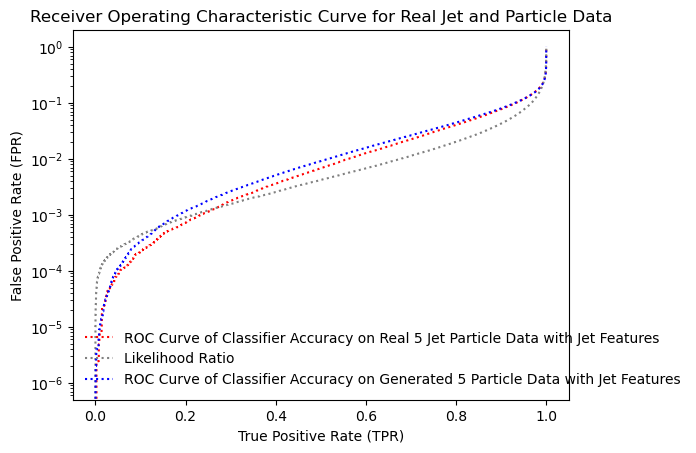

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils

plt.plot(tpr_combine_real,fpr_combine_real,label="ROC Curve of Classifier Accuracy on Real 5 Jet Particle Data with Jet Features",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.plot(tpr,fpr,label="Likelihood Ratio",
                         color='gray',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.plot(tpr_combine_gen,fpr_combine_gen,label="ROC Curve of Classifier Accuracy on Generated 5 Particle Data with Jet Features",
                         color='blue',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Real Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

### Generated Particles only

In [1]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, TimeDistributed
import numpy as np
import h5py as h5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_gluon_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_gluon_ll.h5'
]

def load_data(filepath):
    with h5.File(filepath, "r") as h5f:
        particles = h5f['data'][()].astype(np.float32)
        jets = h5f['jet'][()].astype(np.float32)
        normal_particles = h5f['normal_data'][()].astype(np.float32)
        normal_jets = h5f['normal_jet'][()].astype(np.float32)
    return particles, jets, normal_particles, normal_jets

gen_gluon_parts, gen_gluon_jets, gluon_parts, gluon_jets = load_data(filepaths[0])
gen_top_parts, gen_top_jets, top_parts, top_jets = load_data(filepaths[1])

print("Initial shapes:")
print(gen_gluon_parts.shape)
print(gen_gluon_jets.shape)
print(gluon_parts.shape)
print(gluon_jets.shape)
print(gen_top_parts.shape)
print(gen_top_jets.shape)
print(top_parts.shape)
print(top_jets.shape)

def select_top_particles(particles, num_particles=5):
    top_indices = np.argsort(particles[:, :, 2], axis=1)[:, -num_particles:]
    return np.take_along_axis(particles, np.expand_dims(top_indices, axis=-1), axis=1)

gen_gluon_parts = select_top_particles(gen_gluon_parts)
gluon_parts = select_top_particles(gluon_parts)
gen_top_parts = select_top_particles(gen_top_parts)
top_parts = select_top_particles(top_parts)

# Remove the jet features and keep only the first 3 particle features
gen_gluon_parts = gen_gluon_parts[:, :, :3]
gluon_parts = gluon_parts[:, :, :3]
gen_top_parts = gen_top_parts[:, :, :3]
top_parts = top_parts[:, :, :3]

# Ensure there are enough samples
num_samples = min(gen_gluon_parts.shape[0], gen_top_parts.shape[0], 600000)

labels_gluon = np.zeros((num_samples, 1))
labels_top = np.ones((num_samples, 1))

X = np.concatenate([gen_gluon_parts[:num_samples], gen_top_parts[:num_samples]])
y = np.concatenate([labels_gluon[:num_samples], labels_top[:num_samples]])

X_test = np.concatenate([gen_gluon_parts[num_samples:], gen_top_parts[num_samples:]])
y_test = np.concatenate([labels_gluon[num_samples:], labels_top[num_samples:]])

# Standardization
scaler = StandardScaler()
X_flattened = X.reshape(X.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1) if X_test.size > 0 else np.empty((0, X.shape[1]*X.shape[2]))

X_scaled = scaler.fit_transform(X_flattened)
X_test_scaled = scaler.transform(X_test_flattened) if X_test.size > 0 else np.empty_like(X_test_flattened)

X_scaled = X_scaled.reshape(X.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape) if X_test.size > 0 else X_test_flattened

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Print shapes to confirm
print("Reduced gen_gluon_parts shape:", X_train.shape)
print("Reduced gluon_parts shape:", gluon_parts.shape)
print("Reduced gen_top_parts shape:", gen_top_parts.shape)
print("Reduced top_parts shape:", top_parts.shape)



Initial shapes:
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
Reduced gen_gluon_parts shape: (960000, 5, 3)
Reduced gluon_parts shape: (1600000, 5, 3)
Reduced gen_top_parts shape: (1600000, 5, 3)
Reduced top_parts shape: (1600000, 5, 3)


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming your model definition is already provided and instantiated
model_cg = DeepSetsAttClass(num_feat=5, num_transformer=5)

model_cg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cg.load_weights('cg_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_30.h5')

import json

early_stopping_cg = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_cg = ModelCheckpoint('cg_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_{epoch:02d}.h5', save_weights_only=True, period=5, verbose=1)

history = model_cg.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=128,
                    batch_size=32,
                    callbacks=[early_stopping_cg, model_checkpoint_cg])

model_cg.save('ONLY_5particle_5transformer_combined_gen.h5')
predictions_cg = model_cg.predict(X_test_scaled)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_gen, tpr_combine_gen, _ = roc_curve(y_test,predictions_cg, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_gen, tpr_combine_gen)))
plt.plot(tpr_combine_gen,fpr_combine_gen,label="ROC Curve of Classifier Accuracy on Generated 5 Highest pt Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Generated Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

Epoch 1/128


2024-05-30 21:08:18.841185: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 6393/30000 [=====>........................] - ETA: 2:39 - loss: 0.2782 - accuracy: 0.8817

KeyboardInterrupt: 

### real particles only

In [6]:
import h5py as h5
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Dense, TimeDistributed

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_train.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_train.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_test.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_test.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_val.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_val.h5'
]

def load_data(filepath):
    with h5.File(filepath, "r") as h5f:
        particles = h5f['data'][()].astype(np.float32)
        jets = h5f['jet'][()].astype(np.float32)
    return particles, jets

real_gluon_parts, real_gluon_jets = load_data(filepaths[0])
real_top_parts, real_top_jets = load_data(filepaths[1])
real_gluon_parts_test, real_gluon_jets_test = load_data(filepaths[2])
real_top_parts_test, real_top_jets_test = load_data(filepaths[3])
real_gluon_parts_val, real_gluon_jets_val = load_data(filepaths[4])
real_top_parts_val, real_top_jets_val = load_data(filepaths[5])

def select_top_particles(particles, num_particles=5):
    top_indices = np.argsort(particles[:, :, 2], axis=1)[:, -num_particles:]
    return np.take_along_axis(particles, np.expand_dims(top_indices, axis=-1), axis=1)

real_gluon_parts = select_top_particles(real_gluon_parts)
real_top_parts = select_top_particles(real_top_parts)
real_gluon_parts_test = select_top_particles(real_gluon_parts_test)
real_top_parts_test = select_top_particles(real_top_parts_test)
real_gluon_parts_val = select_top_particles(real_gluon_parts_val)
real_top_parts_val = select_top_particles(real_top_parts_val)

# Remove the jet features and keep only the first 3 particle features
real_gluon_parts = real_gluon_parts[:, :, :3]
real_top_parts = real_top_parts[:, :, :3]
real_gluon_parts_test = real_gluon_parts_test[:, :, :3]
real_top_parts_test = real_top_parts_test[:, :, :3]
real_gluon_parts_val = real_gluon_parts_val[:, :, :3]
real_top_parts_val = real_top_parts_val[:, :, :3]

real_gluon_parts_combined = np.concatenate([real_gluon_parts, real_gluon_parts_test, real_gluon_parts_val], axis=0)
real_top_parts_combined = np.concatenate([real_top_parts, real_top_parts_test, real_top_parts_val], axis=0)

labels_gluon_real = np.zeros((real_gluon_parts_combined.shape[0], 1))
labels_top_real = np.ones((real_top_parts_combined.shape[0], 1))

X_real = np.concatenate([real_gluon_parts_combined[:600000], real_top_parts_combined[:600000]])
y_real = np.concatenate([labels_gluon_real[:600000], labels_top_real[:600000]])

X_test_real = np.concatenate([real_gluon_parts_combined[600000:], real_top_parts_combined[600000:]])
y_test_real = np.concatenate([labels_gluon_real[600000:], labels_top_real[600000:]])

scaler_real = StandardScaler()
X_flattened_real = X_real.reshape(X_real.shape[0], -1)
X_test_flattened_real = X_test_real.reshape(X_test_real.shape[0], -1) if X_test_real.size > 0 else np.empty((0, X_real.shape[1]*X_real.shape[2]))

X_scaled_real = scaler_real.fit_transform(X_flattened_real)
X_test_scaled_real = scaler_real.transform(X_test_flattened_real) if X_test_real.size > 0 else np.empty_like(X_test_flattened_real)

X_scaled_real = X_scaled_real.reshape(X_real.shape)
X_test_scaled_real = X_test_scaled_real.reshape(X_test_real.shape) if X_test_real.size > 0 else X_test_flattened_real

X_train_real, X_val_real, y_train_real, y_val_real = train_test_split(X_scaled_real, y_real, test_size=0.2, random_state=42)

def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Print shapes to confirm
print("Combined real_gluon_parts shape:", real_gluon_parts_combined.shape)
print("Combined real_top_parts shape:", real_top_parts_combined.shape)
print("Training data shape:", X_train_real.shape)
print("Validation data shape:", X_val_real.shape)
print("Test data shape:", X_test_real.shape)


Combined real_gluon_parts shape: (1008940, 5, 3)
Combined real_top_parts shape: (1009060, 5, 3)
Training data shape: (960000, 5, 3)
Validation data shape: (240000, 5, 3)
Test data shape: (818000, 5, 3)


Epoch 1/128
30000/30000 [==============================] - 223s 7ms/step - loss: 0.3036 - accuracy: 0.8697 - val_loss: 0.2851 - val_accuracy: 0.8767
Epoch 2/128
30000/30000 [==============================] - 216s 7ms/step - loss: 0.2880 - accuracy: 0.8759 - val_loss: 0.2822 - val_accuracy: 0.8785
Epoch 3/128
30000/30000 [==============================] - 219s 7ms/step - loss: 0.2848 - accuracy: 0.8769 - val_loss: 0.2807 - val_accuracy: 0.8786
Epoch 4/128
30000/30000 [==============================] - 218s 7ms/step - loss: 0.2830 - accuracy: 0.8777 - val_loss: 0.2806 - val_accuracy: 0.8787
Epoch 5/128
29998/30000 [============================>.] - ETA: 0s - loss: 0.2817 - accuracy: 0.8783
Epoch 5: saving model to cr_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_05.h5
30000/30000 [==============================] - 215s 7ms/step - loss: 0.2817 - accuracy: 0.8783 - val_loss: 0.2795 - val_accuracy: 0.8793
Epoch 6/128
30000/30000 [==============================] - 217s 7ms/

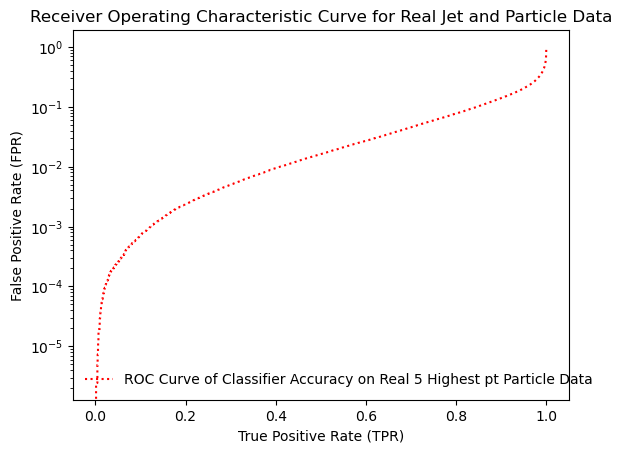

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LayerNormalization, MultiHeadAttention, GlobalAvgPool1D, LeakyReLU, Dropout

model_cr = DeepSetsAttClass(num_feat=3, num_transformer=5)

model_cr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping_cr = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_cr = ModelCheckpoint('cr_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_{epoch:02d}.h5', save_weights_only=True, period=5, verbose=1)

history_real = model_cr.fit(X_train_real, y_train_real,
                    validation_data=(X_val_real, y_val_real),
                    epochs=128,
                    batch_size=32,
                    callbacks=[early_stopping_cr, model_checkpoint_cr])
import json
with open('/pscratch/sd/n/nishank/scripts/history_transformers/history_cr_ONLY_5particle_5transformer.json', 'w') as f:
    json.dump(history_real.history, f)
model_cr.save('ONLY_5particle_5transformer_combined_real.h5')

predictions_cr = model_cr.predict(X_test_scaled_real)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_real, tpr_combine_real, _ = roc_curve(y_test_real,predictions_cr, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_real, tpr_combine_real)))
plt.plot(tpr_combine_real,fpr_combine_real,label="ROC Curve of Classifier Accuracy on Real 5 Highest pt Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Real Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

25563/25563 [==============================] - 92s 4ms/step
Classifier AUC: 0.9517998190050235


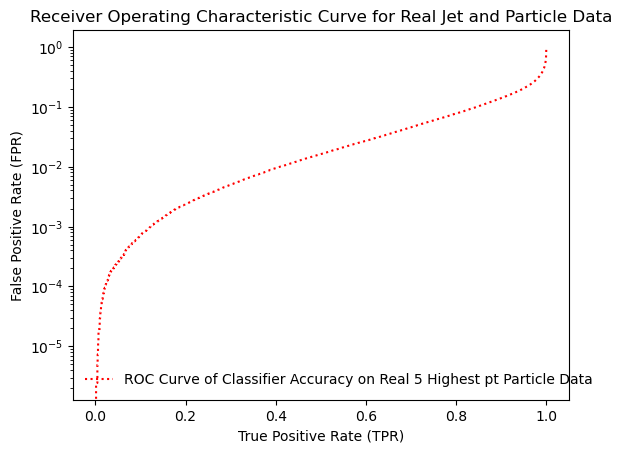

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LayerNormalization, MultiHeadAttention, GlobalAvgPool1D, LeakyReLU, Dropout

model_cr = DeepSetsAttClass(num_feat=3, num_transformer=5)

model_cr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cr.load_weights('ONLY_5particle_5transformer_combined_real.h5')
predictions_cr = model_cr.predict(X_test_scaled_real)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_real, tpr_combine_real, _ = roc_curve(y_test_real,predictions_cr, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_real, tpr_combine_real)))
plt.plot(tpr_combine_real,fpr_combine_real,label="ROC Curve of Classifier Accuracy on Real 5 Highest pt Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Real Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

### generated particles only

In [4]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, TimeDistributed
import numpy as np
import h5py as h5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filepaths = [
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_gluon_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/gluon_model_top_ll.h5',
    '/global/cfs/cdirs/m3246/vmikuni/TOP/top_model_gluon_ll.h5'
]

def load_data(filepath):
    with h5.File(filepath, "r") as h5f:
        particles = h5f['data'][()].astype(np.float32)
        jets = h5f['jet'][()].astype(np.float32)
        normal_particles = h5f['normal_data'][()].astype(np.float32)
        normal_jets = h5f['normal_jet'][()].astype(np.float32)
    return particles, jets, normal_particles, normal_jets

gen_gluon_parts, gen_gluon_jets, gluon_parts, gluon_jets = load_data(filepaths[0])
gen_top_parts, gen_top_jets, top_parts, top_jets = load_data(filepaths[1])

print(gen_gluon_parts.shape)
print(gen_gluon_jets.shape)
print(gluon_parts.shape)
print(gluon_jets.shape)
print(gen_top_parts.shape)
print(gen_top_jets.shape)
print(top_parts.shape)
print(top_jets.shape)

def select_top_particles(particles, num_particles=5):
    top_indices = np.argsort(particles[:, :, 2], axis=1)[:, -num_particles:]
    return np.take_along_axis(particles, np.expand_dims(top_indices, axis=-1), axis=1)

gen_gluon_parts = select_top_particles(gen_gluon_parts)
gluon_parts = select_top_particles(gluon_parts)
gen_top_parts = select_top_particles(gen_top_parts)
top_parts = select_top_particles(top_parts)

# Remove the jet features and keep only the first 3 particle features
gen_gluon_parts = gen_gluon_parts[:, :, :3]
gluon_parts = gluon_parts[:, :, :3]
gen_top_parts = gen_top_parts[:, :, :3]
top_parts = top_parts[:, :, :3]

labels_gluon = np.zeros((gen_gluon_parts.shape[0], 1))
labels_top = np.ones((gen_top_parts.shape[0], 1))

X = np.concatenate([gen_gluon_parts[:600000], gen_top_parts[:600000]])
y = np.concatenate([labels_gluon[:600000], labels_top[:600000]])

X_test = np.concatenate([gen_gluon_parts[600000:], gen_top_parts[600000:]])
y_test = np.concatenate([labels_gluon[600000:], labels_top[600000:]])

# Standardization
scaler = StandardScaler()
X_flattened = X.reshape(X.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1) if X_test.size > 0 else np.empty((0, X.shape[1]*X.shape[2]))

X_scaled = scaler.fit_transform(X_flattened)
X_test_scaled = scaler.transform(X_test_flattened) if X_test.size > 0 else np.empty_like(X_test_flattened)

X_scaled = X_scaled.reshape(X.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape) if X_test.size > 0 else X_test_flattened

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Print shapes to confirm
print("Reduced gen_gluon_parts shape:", gen_gluon_parts.shape)
print("Reduced gluon_parts shape:", gluon_parts.shape)
print("Reduced gen_top_parts shape:", gen_top_parts.shape)
print("Reduced top_parts shape:", top_parts.shape)
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
(1600000, 100, 3)
(1600000, 2)
Reduced gen_gluon_parts shape: (1600000, 5, 3)
Reduced gluon_parts shape: (1600000, 5, 3)
Reduced gen_top_parts shape: (1600000, 5, 3)
Reduced top_parts shape: (1600000, 5, 3)
Training data shape: (960000, 5, 3)
Validation data shape: (240000, 5, 3)
Test data shape: (2000000, 5, 3)


Epoch 1/128
30000/30000 [==============================] - 215s 7ms/step - loss: 0.2785 - accuracy: 0.8822 - val_loss: 0.2834 - val_accuracy: 0.8791
Epoch 2/128
30000/30000 [==============================] - 211s 7ms/step - loss: 0.2783 - accuracy: 0.8818 - val_loss: 0.2841 - val_accuracy: 0.8793
Epoch 3/128
30000/30000 [==============================] - 210s 7ms/step - loss: 0.2781 - accuracy: 0.8820 - val_loss: 0.2845 - val_accuracy: 0.8791
Epoch 4/128
30000/30000 [==============================] - 214s 7ms/step - loss: 0.2780 - accuracy: 0.8822 - val_loss: 0.2842 - val_accuracy: 0.8788
Epoch 5/128
29999/30000 [============================>.] - ETA: 0s - loss: 0.2779 - accuracy: 0.8820
Epoch 5: saving model to cg_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_05.h5
30000/30000 [==============================] - 210s 7ms/step - loss: 0.2779 - accuracy: 0.8820 - val_loss: 0.2829 - val_accuracy: 0.8791
Epoch 6/128
30000/30000 [==============================] - 207s 7ms/

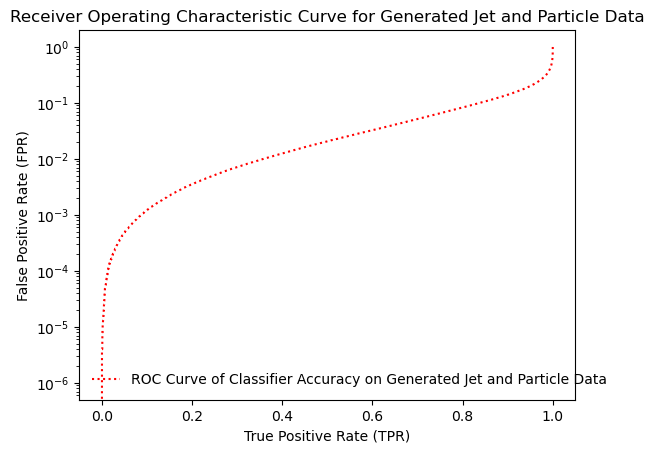

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming your model definition is already provided and instantiated
model_cg = DeepSetsAttClass(num_feat=3, num_transformer=5)

model_cg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cg.load_weights('cg_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_30.h5')
import json

early_stopping_cg = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint_cg = ModelCheckpoint('cg_transformers_checkpoints/ONLY_5particle_5transformer_checkpoint_{epoch:02d}.h5', save_weights_only=True, period=5, verbose=1)

history = model_cg.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=128,
                    batch_size=32,
                    callbacks=[early_stopping_cg, model_checkpoint_cg])
model_cg.save('ONLY_5particle_5transformer_combined_gen.h5')
predictions_cg = model_cg.predict(X_test_scaled)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import utils
fpr_combine_gen, tpr_combine_gen, _ = roc_curve(y_test,predictions_cg, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_combine_gen, tpr_combine_gen)))
plt.plot(tpr_combine_gen,fpr_combine_gen,label="ROC Curve of Classifier Accuracy on Generated Jet and Particle Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Generated Jet and Particle Data')  # Plot title
plt.yscale('log')
plt.legend(frameon=False,fontsize=10)
plt.show()

### all particle curves

Classifier AUC: 0.9674610216035


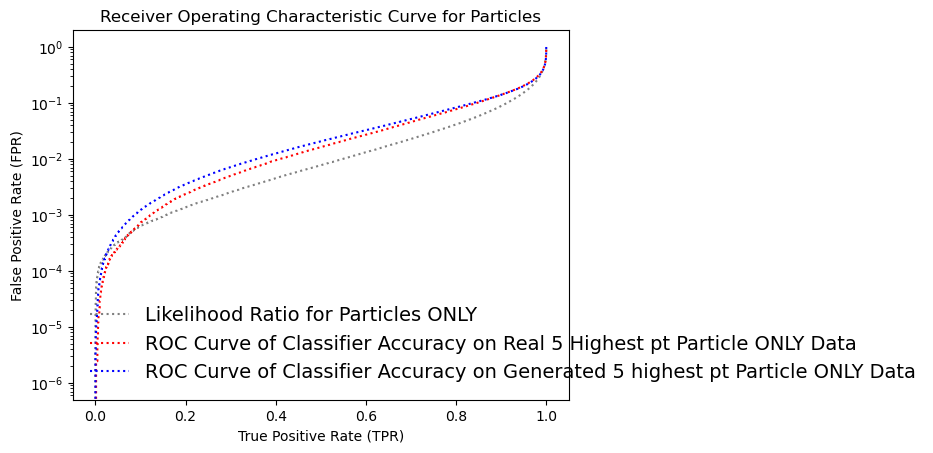

In [9]:
llr_gluon_parts = gluon_model_top_ll_parts - gluon_model_gluon_ll_parts

llr_top_parts =  top_model_top_ll_parts - top_model_gluon_ll_parts

llr_parts = np.concatenate([llr_top_parts, llr_gluon_parts], 0)
labels_parts_llr = np.concatenate([np.ones(llr_top_parts.shape[0]), np.zeros(llr_gluon_parts.shape[0])], 0)

fpr_parts_ll, tpr_parts_ll, _ = roc_curve(labels_parts_llr,llr_parts, pos_label=1)
print("Classifier AUC: {}".format(auc(fpr_parts_ll, tpr_parts_ll)))
plt.plot(tpr_parts_ll,fpr_parts_ll,label="Likelihood Ratio for Particles ONLY",
                         color='gray',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.plot(tpr_combine_real,fpr_combine_real,label="ROC Curve of Classifier Accuracy on Real 5 Highest pt Particle ONLY Data",
                         color='red',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.plot(tpr_combine_gen,fpr_combine_gen,label="ROC Curve of Classifier Accuracy on Generated 5 highest pt Particle ONLY Data",
                         color='blue',
                         linestyle=utils.line_style['top_tagging_ll'])
plt.ylabel('False Positive Rate (FPR)')  # X-axis title
plt.xlabel('True Positive Rate (TPR)')  # Y-axis title
plt.title('Receiver Operating Characteristic Curve for Particles')
plt.yscale('log')
plt.legend(frameon=False,fontsize=14)
plt.show()

In [ ]:
improvements